Importing Libraries and the dataset

In [13]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import entropy, pearsonr

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
df = pd.read_csv('/content/drive/MyDrive/finalproject/merged_data_projectb.csv')

Preprocesing and splitting the data

In [16]:
df1 = df
cols = ['FSO_Att','RFL_Att']
x = df1.drop(cols, axis=1)
y2 = df1['RFL_Att']
y1 = df1['FSO_Att']

In [17]:

X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(
    x, y1, y2, test_size=0.3, random_state=42
)

Contstructing the model

Best RMSE for y1: 1.5070456743016098
Best R² for y1: 0.922298929992702
Features for best y1: ['AbsoluteHumidity', 'AbsoluteHumidityMax', 'AbsoluteHumidityMin', 'Distance', 'Particulate', 'ParticulateMax', 'ParticulateMin', 'RelativeHumidity', 'SYNOPCode', 'Temperature', 'TemperatureDifference', 'TemperatureMax', 'TemperatureMin', 'Time', 'Visibility', 'VisibilityMax', 'VisibilityMin', 'WindSpeedMax']

RMSE for y2: 1.0501082467175904
R² for y2: 0.8537615025984208


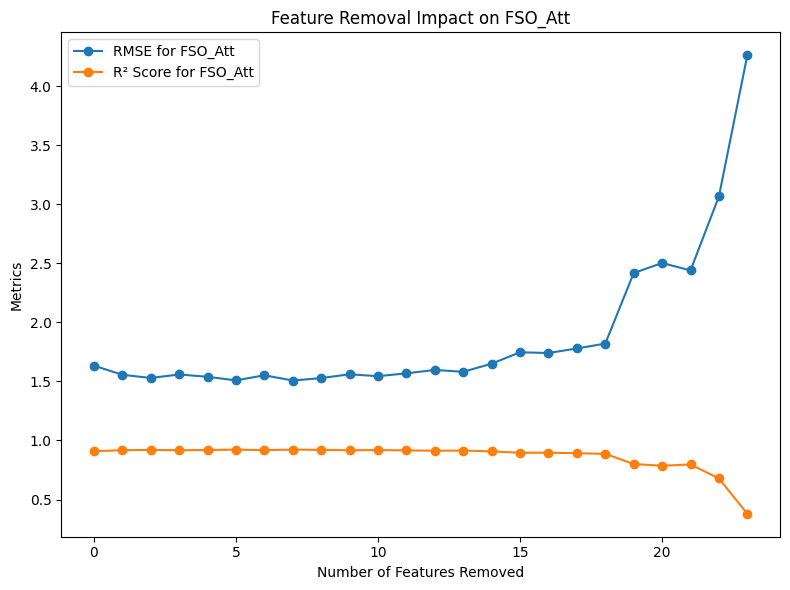

In [18]:

# Function to calculate metrics
def evaluate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

# DataFrames to store the best predictions for y1 and y2
best_predictions_y1 = pd.DataFrame()
best_predictions_y2 = pd.DataFrame()


X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(
    x, y1, y2, test_size=0.3, random_state=42
)


rmse_y1_list, r2_y1_list, features_y1_list = [], [], []
best_rmse_y1, best_r2_y1, best_features_y1 = float('inf'), -float('inf'), []
best_y1_predictions = None


X_train_current = X_train.copy()
X_test_current = X_test.copy()

# Iteratively remove least significant features for y1 prediction
while X_train_current.shape[1] > 1:
    # Train Extra Trees Regressor with OOB for y1
    model_y1 = ExtraTreesRegressor(random_state=42, oob_score=True, bootstrap=True)
    model_y1.fit(X_train_current, y1_train)

    # Predict y1
    y1_test_pred = model_y1.predict(X_test_current)

    # Evaluate metrics
    _, rmse_y1, _, r2_y1 = evaluate_metrics(y1_test, y1_test_pred)
    rmse_y1_list.append(rmse_y1)
    r2_y1_list.append(r2_y1)
    features_y1_list.append(X_train_current.columns.tolist())

    # Update best metrics, features, and predictions
    if rmse_y1 < best_rmse_y1:
        best_rmse_y1 = rmse_y1
        best_r2_y1 = r2_y1
        best_features_y1 = X_train_current.columns.tolist()  # Store best features
        best_y1_predictions = y1_test_pred  # Save the predictions

    # Remove least significant feature
    importances = model_y1.feature_importances_
    least_significant_feature = X_train_current.columns[np.argmin(importances)]
    X_train_current = X_train_current.drop(columns=[least_significant_feature])
    X_test_current = X_test_current.drop(columns=[least_significant_feature])

# Store the best y1 predictions in a DataFrame
best_predictions_y1['SYNOPCode'] = X_test['SYNOPCode']  # Add SYNOPCode from the test data
best_predictions_y1['Actual_y1'] = y1_test
best_predictions_y1['Predicted_y1'] = best_y1_predictions

# Adding the predicted y1 to the dataframe for y2 prediction
X_train_with_y1 = X_train[best_features_y1].copy()
X_train_with_y1['y1'] = y1_train

X_test_with_y1 = X_test[best_features_y1].copy()
X_test_with_y1['y1'] = best_y1_predictions

# Train Extra Trees Regressor for y2 using the selected features
model_y2 = ExtraTreesRegressor(random_state=42, oob_score=True, bootstrap=True)
model_y2.fit(X_train_with_y1, y2_train)

# Predict y2
y2_test_pred = model_y2.predict(X_test_with_y1)

# Evaluate metrics for y2
_, rmse_y2, _, r2_y2 = evaluate_metrics(y2_test, y2_test_pred)

# Store the best y2 predictions in a DataFrame
best_predictions_y2['SYNOPCode'] = X_test['SYNOPCode']  # Add SYNOPCode from the test data
best_predictions_y2['Actual_y2'] = y2_test
best_predictions_y2['Predicted_y2'] = y2_test_pred


print(f"Best RMSE for y1: {best_rmse_y1}")
print(f"Best R² for y1: {best_r2_y1}")
print(f"Features for best y1: {best_features_y1}")


print(f"\nRMSE for y2: {rmse_y2}")
print(f"R² for y2: {r2_y2}")

# Plot RMSE and R² for y1
plt.figure(figsize=(8, 6))
plt.plot(range(len(rmse_y1_list)), rmse_y1_list, marker='o', label='RMSE for FSO_Att')
plt.plot(range(len(r2_y1_list)), r2_y1_list, marker='o', label='R² Score for FSO_Att')
plt.xlabel('Number of Features Removed')
plt.ylabel('Metrics')
plt.title('Feature Removal Impact on FSO_Att')
plt.legend()
plt.tight_layout()
plt.show()

# Save the best predictions to files
best_predictions_y1.to_csv('best_predictions_y1.csv', index=False)
best_predictions_y2.to_csv('best_predictions_y2.csv', index=False)


Generating Heatmaps based on probability density

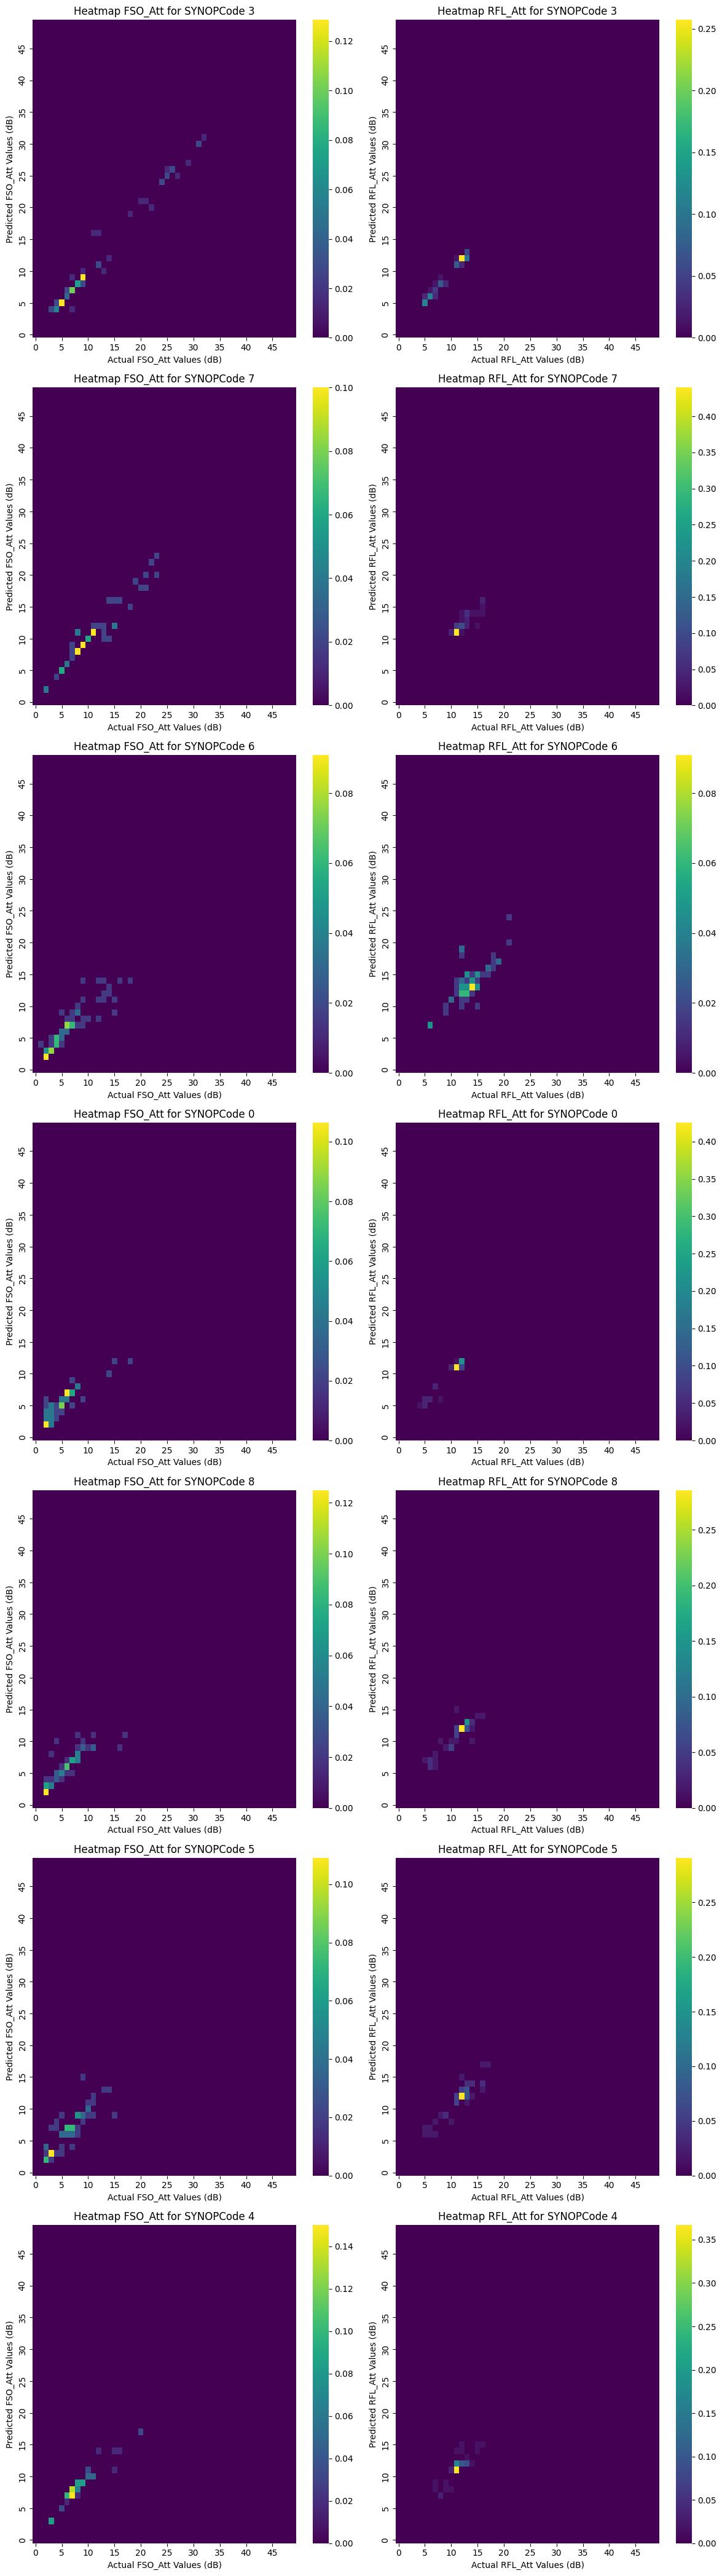


Entropy and Mutual Information Results:
   SYNOPCode    H_X_y1    H_Y_y1   H_XY_y1  Mutual_Info_y1  Normalized_MI_y1  \
0          3  3.896183  3.766855  4.428216        3.234821          0.730502   
1          7  4.032949  3.728884  4.597082        3.164751          0.688426   
2          6  3.669998  3.473251  4.900698        2.242552          0.457598   
3          0  3.007328  3.026717  4.406202        1.627843          0.369443   
4          8  3.260580  3.227351  4.480914        2.007017          0.447903   
5          5  3.462418  3.192750  4.758366        1.896802          0.398625   
6          4  3.107867  2.892424  3.800594        2.199696          0.578777   

     H_X_y2    H_Y_y2   H_XY_y2  Mutual_Info_y2  Normalized_MI_y2  
0  2.775422  2.573819  3.462364        1.886877          0.544968  
1  2.086598  1.933410  3.034416        0.985592          0.324804  
2  3.235367  3.305483  4.911152        1.629697          0.331836  
3  2.160086  1.753957  2.625699        1.28834

In [19]:


results = []

# Collect unique SYNOPCodes
unique_synop_codes = best_predictions_y1['SYNOPCode'].unique()

# Create a figure for all heatmaps
num_synop_codes = len(unique_synop_codes)
fig, axes = plt.subplots(num_synop_codes, 2, figsize=(12, 6 * num_synop_codes))

for i, synop_code in enumerate(unique_synop_codes):
    # Filter the data for the current SYNOPCode
    df_filtered_y1 = best_predictions_y1[best_predictions_y1['SYNOPCode'] == synop_code]
    df_filtered_y2 = best_predictions_y2[best_predictions_y2['SYNOPCode'] == synop_code]


    y1_actual = df_filtered_y1['Actual_y1']
    y1_predicted = df_filtered_y1['Predicted_y1']


    heatmap_data_y1, xedges_y1, yedges_y1 = np.histogram2d(y1_actual, y1_predicted, bins=50, range=[[0, 50], [0, 50]])
    joint_prob_y1 = heatmap_data_y1 / heatmap_data_y1.sum()


    sns.heatmap(joint_prob_y1.T, cmap='viridis', ax=axes[i, 0], cbar=True, xticklabels=5, yticklabels=5)
    axes[i, 0].invert_yaxis()
    axes[i, 0].set_title(f'Heatmap FSO_Att for SYNOPCode {synop_code}')
    axes[i, 0].set_xlabel('Actual FSO_Att Values (dB)')
    axes[i, 0].set_ylabel('Predicted FSO_Att Values (dB)')

    # Calculate entropies and mutual information for y1
    marginal_x_y1 = joint_prob_y1.sum(axis=1)
    marginal_y_y1 = joint_prob_y1.sum(axis=0)
    H_X_y1 = entropy(marginal_x_y1, base=2)
    H_Y_y1 = entropy(marginal_y_y1, base=2)
    H_XY_y1 = entropy(joint_prob_y1.ravel(), base=2)
    mutual_information_y1 = H_X_y1 + H_Y_y1 - H_XY_y1

    y2_actual = df_filtered_y2['Actual_y2']
    y2_predicted = df_filtered_y2['Predicted_y2']

    heatmap_data_y2, xedges_y2, yedges_y2 = np.histogram2d(y2_actual, y2_predicted, bins=50, range=[[0, 50], [0, 50]])
    joint_prob_y2 = heatmap_data_y2 / heatmap_data_y2.sum()


    sns.heatmap(joint_prob_y2.T, cmap='viridis', ax=axes[i, 1], cbar=True, xticklabels=5, yticklabels=5)
    axes[i, 1].invert_yaxis()
    axes[i, 1].set_title(f'Heatmap RFL_Att for SYNOPCode {synop_code}')
    axes[i, 1].set_xlabel('Actual RFL_Att Values (dB)')
    axes[i, 1].set_ylabel('Predicted RFL_Att Values (dB)')

    # Calculate entropies and mutual information for y2
    marginal_x_y2 = joint_prob_y2.sum(axis=1)
    marginal_y_y2 = joint_prob_y2.sum(axis=0)
    H_X_y2 = entropy(marginal_x_y2, base=2)
    H_Y_y2 = entropy(marginal_y_y2, base=2)
    H_XY_y2 = entropy(joint_prob_y2.ravel(), base=2)
    mutual_information_y2 = H_X_y2 + H_Y_y2 - H_XY_y2

    # Store results in a dictionary
    results.append({
        'SYNOPCode': synop_code,
        'H_X_y1': H_X_y1,
        'H_Y_y1': H_Y_y1,
        'H_XY_y1': H_XY_y1,
        'Mutual_Info_y1': mutual_information_y1,
        'Normalized_MI_y1': mutual_information_y1 / H_XY_y1,
        'H_X_y2': H_X_y2,
        'H_Y_y2': H_Y_y2,
        'H_XY_y2': H_XY_y2,
        'Mutual_Info_y2': mutual_information_y2,
        'Normalized_MI_y2': mutual_information_y2 / H_XY_y2
    })


plt.tight_layout()
plt.show()


results_df = pd.DataFrame(results)


results_df.to_csv('entropy_mutual_information_results.csv', index=False)


print("\nEntropy and Mutual Information Results:")
print(results_df)


Calculating Pearson Coefficients

In [ ]:


results = []

unique_synop_codes = best_predictions_y1['SYNOPCode'].unique()

num_synop_codes = len(unique_synop_codes)
fig, axes = plt.subplots(num_synop_codes, 2, figsize=(12, 6 * num_synop_codes))


pearson_results_y1 = []
pearson_results_y2 = []
normalized_mi_results_y1 = []
normalized_mi_results_y2 = []

for i, synop_code in enumerate(unique_synop_codes):

    df_filtered_y1 = best_predictions_y1[best_predictions_y1['SYNOPCode'] == synop_code]
    df_filtered_y2 = best_predictions_y2[best_predictions_y2['SYNOPCode'] == synop_code]


    y1_actual = df_filtered_y1['Actual_y1']
    y1_predicted = df_filtered_y1['Predicted_y1']


    heatmap_data_y1, xedges_y1, yedges_y1 = np.histogram2d(y1_actual, y1_predicted, bins=50, range=[[0, 50], [0, 50]])
    joint_prob_y1 = heatmap_data_y1 / heatmap_data_y1.sum()


    marginal_x_y1 = joint_prob_y1.sum(axis=1)
    marginal_y_y1 = joint_prob_y1.sum(axis=0)
    H_X_y1 = entropy(marginal_x_y1, base=2)
    H_Y_y1 = entropy(marginal_y_y1, base=2)
    H_XY_y1 = entropy(joint_prob_y1.ravel(), base=2)
    mutual_information_y1 = H_X_y1 + H_Y_y1 - H_XY_y1
    normalized_mi_y1 = mutual_information_y1 / H_XY_y1

    y2_actual = df_filtered_y2['Actual_y2']
    y2_predicted = df_filtered_y2['Predicted_y2']

    heatmap_data_y2, xedges_y2, yedges_y2 = np.histogram2d(y2_actual, y2_predicted, bins=50, range=[[0, 50], [0, 50]])
    joint_prob_y2 = heatmap_data_y2 / heatmap_data_y2.sum()


    marginal_x_y2 = joint_prob_y2.sum(axis=1)
    marginal_y_y2 = joint_prob_y2.sum(axis=0)
    H_X_y2 = entropy(marginal_x_y2, base=2)
    H_Y_y2 = entropy(marginal_y_y2, base=2)
    H_XY_y2 = entropy(joint_prob_y2.ravel(), base=2)
    mutual_information_y2 = H_X_y2 + H_Y_y2 - H_XY_y2
    normalized_mi_y2 = mutual_information_y2 / H_XY_y2

    # Calculate Pearson correlation for y1 and y2
    pearson_corr_y1, _ = pearsonr(y1_actual, y1_predicted)
    pearson_corr_y2, _ = pearsonr(y2_actual, y2_predicted)

    # Store results
    results.append({
        'SYNOPCode': synop_code,
        'H_X_y1': H_X_y1,
        'H_Y_y1': H_Y_y1,
        'H_XY_y1': H_XY_y1,
        'Mutual_Info_y1': mutual_information_y1,
        'Normalized_MI_y1': normalized_mi_y1,
        'H_X_y2': H_X_y2,
        'H_Y_y2': H_Y_y2,
        'H_XY_y2': H_XY_y2,
        'Mutual_Info_y2': mutual_information_y2,
        'Normalized_MI_y2': normalized_mi_y2,
        'Pearson_Corr_y1': pearson_corr_y1,
        'Pearson_Corr_y2': pearson_corr_y2
    })

    # Store Pearson correlation and normalized MI for plotting
    pearson_results_y1.append(pearson_corr_y1)
    pearson_results_y2.append(pearson_corr_y2)
    normalized_mi_results_y1.append(normalized_mi_y1)
    normalized_mi_results_y2.append(normalized_mi_y2)



results_df = pd.DataFrame(results)


results_df.to_csv('entropy_mutual_information_pearson_results.csv', index=False)



In [22]:
results_df

,SYNOPCode,H_X_y1,H_Y_y1,H_XY_y1,Mutual_Info_y1,Normalized_MI_y1,H_X_y2,H_Y_y2,H_XY_y2,Mutual_Info_y2,Normalized_MI_y2,Pearson_Corr_y1,Pearson_Corr_y2
0,3,3.896183,3.766855,4.428216,3.234821,0.730502,2.775422,2.573819,3.462364,1.886877,0.544968,0.991089,0.990471
1,7,4.032949,3.728884,4.597082,3.164751,0.688426,2.086598,1.933410,3.034416,0.985592,0.324804,0.965954,0.900367
2,6,3.669998,3.473251,4.900698,2.242552,0.457598,3.235367,3.305483,4.911152,1.629697,0.331836,0.914426,0.772875
3,0,3.007328,3.026717,4.406202,1.627843,0.369443,2.160086,1.753957,2.625699,1.288344,0.490667,0.881504,0.979726
4,8,3.260580,3.227351,4.480914,2.007017,0.447903,2.954240,2.615066,3.731200,1.838106,0.492631,0.856778,0.911583
5,5,3.462418,3.192750,4.758366,1.896802,0.398625,2.858506,2.634839,3.922002,1.571342,0.400648,0.857361,0.932504
6,4,3.107867,2.892424,3.800594,2.199696,0.578777,2.261396,2.133370,3.199454,1.195312,0.373599,0.963245,0.888961


Plotting Pearsons correlation coefficients and Normalized Mutual Information coefficients against SYNOP Code

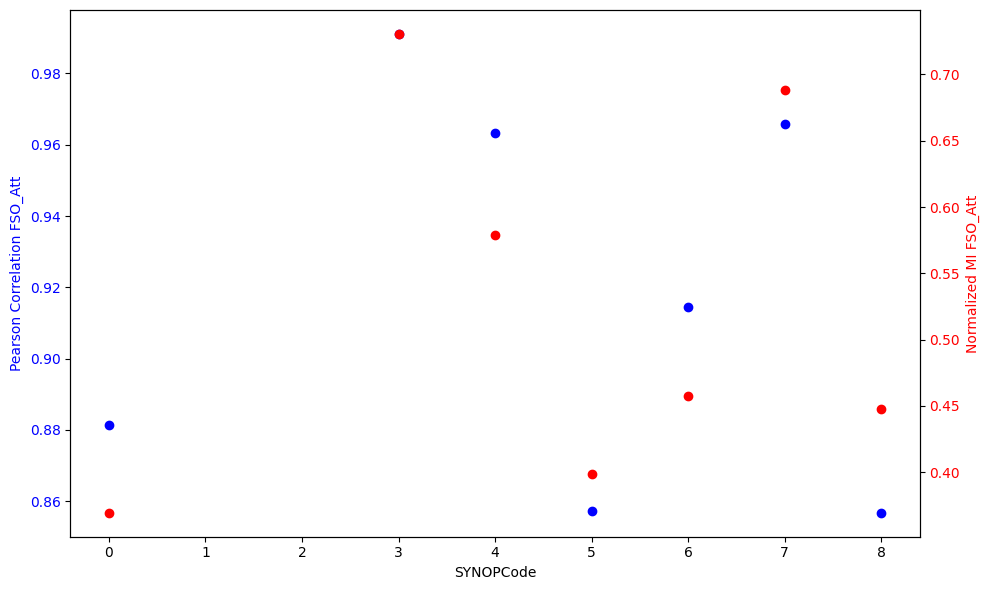

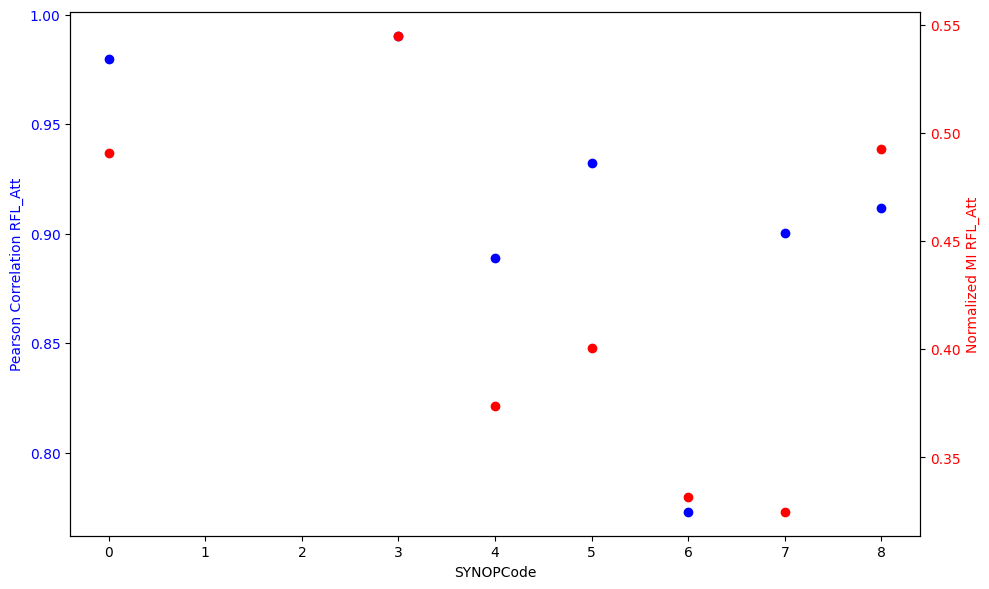

In [23]:

synop_codes = results_df['SYNOPCode']
pearson_corr_y1 = abs(results_df['Pearson_Corr_y1'])
pearson_corr_y2 = abs(results_df['Pearson_Corr_y2'])
normalized_mi_y1 = results_df['Normalized_MI_y1']
normalized_mi_y2 = results_df['Normalized_MI_y2']


fig, ax1 = plt.subplots(figsize=(10, 6))

# Ploting Pearson correlation for y1 (on the left y-axis)
ax1.scatter(synop_codes, pearson_corr_y1, color='blue', label='Pearson Corr FSO_Att', marker='o')
ax1.set_xlabel('SYNOPCode')
ax1.set_ylabel('Pearson Correlation FSO_Att', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Creating a second y-axis to plot Normalized MI (on the right y-axis)
ax2 = ax1.twinx()
ax2.scatter(synop_codes, normalized_mi_y1, color='red', label='Normalized MI FSO_Att', marker='o')
ax2.set_ylabel('Normalized MI FSO_Att', color='red')
ax2.tick_params(axis='y', labelcolor='red')


fig.tight_layout()
plt.show()


fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.scatter(synop_codes, pearson_corr_y2, color='blue', label='Pearson Corr RFL_Att', marker='o')
ax1.set_xlabel('SYNOPCode')
ax1.set_ylabel('Pearson Correlation RFL_Att', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')


ax2 = ax1.twinx()
ax2.scatter(synop_codes, normalized_mi_y2, color='red', label='Normalized MI RFL_Att', marker='o')
ax2.set_ylabel('Normalized MI RFL_Att', color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.show()
